In [1]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
user_features = pd.read_csv('user-features.csv')
item_features = pd.read_csv('item-features.csv')

In [6]:
train

,user_id,item_id,like,timestamp
0,140,342,0,1490936622
1,378,172,1,1490936628
2,150,182,0,1490936650
3,455,17,0,1490936704
4,350,409,0,1490936735
...,...,...,...,...
8669,161,312,0,1491215519
8670,406,208,0,1491215543
8671,196,43,0,1491215576
8672,84,100,0,1491215579


# препроцессинг

In [2]:
user_features.set_index('user_id', inplace=True)
item_features.set_index('item_id', inplace=True)

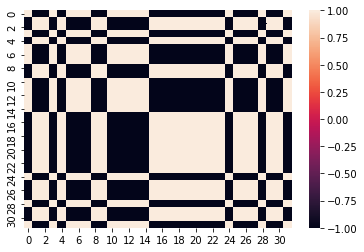

In [3]:
import seaborn as sns

sns.heatmap(user_features.corr())

In [4]:
user_features = user_features['0']

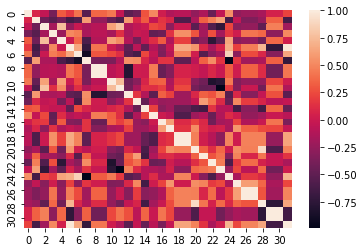

In [5]:
sns.heatmap(item_features.corr())

In [6]:
from sklearn.decomposition import PCA

pca = PCA(32)

In [7]:
pca.fit(item_features.values)

PCA(n_components=32)

In [8]:
pca.explained_variance_ratio_.cumsum() # cumsum r каждому числу прибавляет все предедущие 

array([0.38584675, 0.60198545, 0.73288149, 0.80900286, 0.87650087,
       0.92317195, 0.95056808, 0.97193468, 0.98592696, 0.99606962,
       0.99977595, 0.99994347, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [9]:
item_features = item_features.loc[:, item_features.columns[:12]]

# baseline

In [10]:
item_to_count = dict()
for item in train[train.like == 1]['item_id'].values:
    try:
        item_to_count[item] += 1
    except:
        item_to_count[item] = 1

In [11]:
item_to_count

{172: 15,
 196: 4,
 123: 4,
 66: 32,
 60: 24,
 94: 5,
 146: 22,
 15: 3,
 40: 48,
 62: 8,
 7: 22,
 87: 21,
 76: 97,
 105: 5,
 28: 2,
 18: 11,
 21: 23,
 77: 8,
 37: 44,
 32: 23,
 129: 7,
 6: 5,
 35: 76,
 11: 25,
 181: 5,
 110: 4,
 1: 6,
 184: 5,
 67: 23,
 65: 38,
 30: 13,
 155: 14,
 159: 6,
 75: 7,
 58: 41,
 198: 3,
 72: 55,
 119: 19,
 22: 77,
 98: 5,
 63: 11,
 113: 6,
 122: 5,
 141: 6,
 148: 2,
 78: 19,
 3: 3,
 31: 3,
 178: 1,
 5: 21,
 180: 6,
 33: 19,
 53: 4,
 81: 3,
 44: 20,
 101: 9,
 90: 10,
 143: 2,
 142: 9,
 109: 1,
 137: 7,
 80: 42,
 136: 10,
 100: 3,
 9: 7,
 20: 5,
 89: 5,
 36: 14,
 83: 5,
 34: 6,
 171: 1,
 39: 15,
 45: 6,
 103: 3,
 70: 13,
 84: 7,
 49: 11,
 17: 14,
 191: 1,
 13: 2,
 59: 12,
 73: 6,
 2: 9,
 112: 3,
 204: 1,
 147: 15,
 41: 9,
 0: 2,
 38: 4,
 139: 2,
 164: 2,
 150: 4,
 125: 4,
 138: 5,
 194: 1,
 157: 1,
 195: 2,
 14: 4,
 71: 11,
 111: 3,
 166: 2,
 27: 4,
 19: 13,
 54: 2,
 51: 1,
 96: 3,
 43: 7,
 16: 2,
 162: 1,
 197: 1,
 203: 1,
 118: 7,
 126: 1,
 121: 1,
 8: 3,
 2

In [37]:
item_id_likes = train.groupby('item_id').sum().reset_index()[['item_id', 'like']]

In [38]:
item_id_likes['like'] *= -1
item_id_likes.sort_values(by=['like'], inplace=True)

In [39]:
baseline_1 = item_id_likes.item_id.values[:20]

In [68]:
baseline_2 = []
for i in range(497):
    df = train[train.user_id == i]
    items = df[df.like == 1].item_id.values
    if len(items) == 0:
        items = item_id_likes.item_id.values[:20]
    else:
        items = np.concatenate((items, item_id_likes.item_id[:20-len(items)].values))
    baseline_2.append(items)

In [47]:
baseline_1_df = pd.DataFrame({'user_id': range(497)})

In [48]:
for i in range(20):
    baseline_1_df[str(i)] = baseline_1[i]

In [95]:
baseline_2_df = pd.DataFrame({'user_id': range(497)})

In [96]:
for i in range(20):
    val = []
    for row in baseline_2:
        val.append(row[i])
    baseline_2_df[str(i)] = val

In [98]:
baseline_1_df.to_csv('baseline_1.csv')

In [99]:
baseline_2_df.to_csv('baseline_2.csv')

# С дизами

In [147]:
item_no_like = dict()
for item in train['item_id'].values:
    a = train[train.like == 1][train.item_id == item]
    b = train[train.like == 0][train.item_id == item]
    c = train[train.item_id == item]
    if len(a) > len(b):
        item_no_like[item] = len(a) - len(b)

    


c:\users\korowood\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\korowood\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [103]:
item_no_like

{66: 32,
 39: 15,
 60: 24,
 26: 7,
 146: 22,
 15: 3,
 40: 48,
 119: 19,
 7: 22,
 87: 21,
 76: 97,
 105: 5,
 28: 2,
 18: 11,
 21: 23,
 77: 8,
 37: 44,
 32: 23,
 155: 14,
 6: 5,
 35: 76,
 67: 23,
 11: 25,
 122: 5,
 110: 4,
 1: 6,
 65: 38,
 2: 9,
 75: 7,
 58: 41,
 72: 55,
 22: 77,
 98: 5,
 113: 6,
 141: 6,
 148: 2,
 78: 19,
 3: 3,
 31: 3,
 5: 21,
 33: 19,
 8: 3,
 81: 3,
 95: 6,
 142: 9,
 114: 5,
 80: 42,
 163: 2,
 136: 10,
 130: 1,
 131: 3,
 160: 3,
 36: 14,
 83: 5,
 34: 6,
 147: 15,
 104: 7,
 49: 11,
 191: 1,
 59: 12,
 73: 6,
 88: 11,
 164: 2,
 150: 4,
 111: 3,
 19: 13,
 51: 1,
 99: 6,
 126: 1,
 192: 2,
 144: 1,
 186: 3,
 145: 4,
 102: 2,
 161: 1,
 61: 1,
 193: 2,
 91: 1,
 200: 1,
 201: 1,
 85: 1,
 56: 1,
 68: 1}

In [155]:
a = train[train['item_id'] == 136][train['like'] == 0]
b = train[train['item_id'] == 136][train['like'] == 1]
len(a), len(b)

c:\users\korowood\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
c:\users\korowood\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(5, 10)

In [148]:
list_d = list(item_no_like.items())
baseline_3 = []
list_d.sort(key=lambda i: -i[1])
for i in list_d:
#     print(i[0], ':', i[1])
    baseline_3.append(i[0])

In [149]:
baseline_3[:20]

[76,
 22,
 35,
 72,
 37,
 40,
 80,
 65,
 58,
 66,
 60,
 7,
 21,
 19,
 11,
 147,
 49,
 1,
 142,
 136]

In [150]:
baseline_3 = baseline_3[:20]
baseline_3_df = pd.DataFrame({'user_id': range(497)})
for i in range(20):
    baseline_3_df[str(i)] = baseline_3[i]

In [151]:
baseline_3_df

,user_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,76,22,35,72,37,40,80,65,58,...,60,7,21,19,11,147,49,1,142,136
1,1,76,22,35,72,37,40,80,65,58,...,60,7,21,19,11,147,49,1,142,136
2,2,76,22,35,72,37,40,80,65,58,...,60,7,21,19,11,147,49,1,142,136
3,3,76,22,35,72,37,40,80,65,58,...,60,7,21,19,11,147,49,1,142,136
4,4,76,22,35,72,37,40,80,65,58,...,60,7,21,19,11,147,49,1,142,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,492,76,22,35,72,37,40,80,65,58,...,60,7,21,19,11,147,49,1,142,136
493,493,76,22,35,72,37,40,80,65,58,...,60,7,21,19,11,147,49,1,142,136
494,494,76,22,35,72,37,40,80,65,58,...,60,7,21,19,11,147,49,1,142,136
495,495,76,22,35,72,37,40,80,65,58,...,60,7,21,19,11,147,49,1,142,136


In [156]:
baseline_3_df.to_csv('baseline_3.csv')

In [70]:
a = train[train['item_id'] == 0][train['like'] == 0]
b = train[train['item_id'] == 0][train['like'] == 1]
c = train[train.like == 0][train.item_id == 0]
c

c:\users\korowood\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
c:\users\korowood\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
c:\users\korowood\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,item_id,like,timestamp
343,5,0,0,1490946983
1432,16,0,0,1490980845
1675,1,0,0,1490988759
1919,153,0,0,1490996337
2622,450,0,0,1491018116
3306,453,0,0,1491038711
4356,276,0,0,1491071198
5862,75,0,0,1491120869
5966,206,0,0,1491124330
6213,15,0,0,1491131677


In [97]:
baseline_1_df

,user_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,76,22,35,72,40,37,80,58,65,...,11,60,32,67,21,7,146,5,87,44
1,1,76,22,35,72,40,37,80,58,65,...,11,60,32,67,21,7,146,5,87,44
2,2,76,22,35,72,40,37,80,58,65,...,11,60,32,67,21,7,146,5,87,44
3,3,76,22,35,72,40,37,80,58,65,...,11,60,32,67,21,7,146,5,87,44
4,4,76,22,35,72,40,37,80,58,65,...,11,60,32,67,21,7,146,5,87,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,492,76,22,35,72,40,37,80,58,65,...,11,60,32,67,21,7,146,5,87,44
493,493,76,22,35,72,40,37,80,58,65,...,11,60,32,67,21,7,146,5,87,44
494,494,76,22,35,72,40,37,80,58,65,...,11,60,32,67,21,7,146,5,87,44
495,495,76,22,35,72,40,37,80,58,65,...,11,60,32,67,21,7,146,5,87,44
